## GNN_DTI Based Learning

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader                                     
from gnn import gnn
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import metrics
import utils
from train_tools import *
import os, time, shutil, itertools, sys
from IPython.display import clear_output

RDKit WARNING: [19:19:06] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
class Opts: pass

### Options

In [4]:
gnn_opts = Opts()
gnn_opts.n_graph_layer = 4
gnn_opts.d_graph_layer = 140
gnn_opts.n_FC_layer = 4
gnn_opts.d_FC_layer = 128
gnn_opts.initial_mu = 4.46108546619827
gnn_opts.initial_dev = 0.19818493842903845
gnn_opts.dropout_rate = 0.05

In [5]:
learn_opts = Opts()
learn_opts.num_epochs = 1000
learn_opts.lr = 0.001
learn_opts.batch_size = 128

In [6]:
myopts = Opts()
myopts.data_fpath = 'cbidata'
myopts.save_dir = 'save'
#!Important: For production, random train and test may be preferred
myopts.random_stratify = False
myopts.cache_dir = '/tmp/moldata'
#Important! If you repeat experiments within the same dataset version, set to False
myopts.clear_cache = False
myopts.train_keys = 'keys/keys_klifs'
myopts.kinase_list = 'keys/kinase_list'
#Important!: The newest version is 3, still 1 and 2 are acceptible, 4 for silly atom feature disabling setup
myopts.dataset_version = 3
myopts.cpu_count = 10

In [7]:
__ver = myopts.dataset_version
assert __ver in list(range(1, 5))
if __ver == 1:
    import dataset as ds
elif __ver == 2:
    import dataset2 as ds
elif __ver ==  3:
    import dataset3 as ds
else:
    print('This is a silly setup, practically disabling atom features', file=sys.stderr)
    import dataset4 as ds

### Support functions for learning loop

In [8]:
def learn(model, loader, train=True):
    losses = []
    for sample in loader:
        model.zero_grad()
        H, A1, A2, Y, V, keys, _ = sample
        H, A1, A2, Y, V = H.to(device), A1.to(device), A2.to(device), Y.to(device), V.to(device)

        pred = model.train_model((H, A1, A2, V))
        loss = loss_fn(pred, Y)
        if train:
            loss.backward()
            optimizer.step()
        losses.append(loss.data.cpu().numpy())
    mean_loss = np.mean(np.array(losses))
    return mean_loss

def test(model, loader):
    test_true, test_pred, test_label = [], [], []

    saliency_list = []
    n_atom_list = []

    model.eval()
    for i_batch, sample in enumerate(loader):
        model.zero_grad()
        H, A1, A2, Y, V, keys, n_atom = sample
        H, A1, A2, Y, V = H.to(device), A1.to(device), A2.to(device), Y.to(device), V.to(device)

        embed = model.embede(H)
        model.zero_grad()
        pred = model.test_model((embed, A1, A2, V))

        out = torch.sum(pred)
        embed.retain_grad()
        out.backward()
        saliency = embed.grad.clone()
        saliency *= embed.data.clone()

        test_true.append(Y.data.cpu().numpy())
        test_pred.append(pred.data.cpu().numpy())
        test_label.append(keys)
        saliency_list.append(saliency)
        n_atom_list.append(n_atom)

    test_pred = np.concatenate(np.array(test_pred), 0)
    test_true = np.concatenate(np.array(test_true), 0)
    return test_true, test_pred, test_label, saliency_list, n_atom_list

def get_stats(X, y):
    rmse = metrics.mean_squared_error(X, y)**0.5
    mae = metrics.mean_absolute_error(X, y)
    r2 = stats.pearsonr(X, y)
    rho = stats.spearmanr(X, y)
    return rmse, mae, r2[0], rho[0]

def update_train_loss(train_loss, best_train_loss):
    if train_loss < best_train_loss:
        best_train_loss = train_loss
    return best_train_loss

def update_test_loss(model, opts, test_loss, best_val_loss, epoch):
    output = False
    if test_loss < best_val_loss:
        best_val_loss = test_loss
        output = True
    if output:
        torch.save(model.state_dict(), f'{opts.save_dir}/save_{epoch}.pt')
        torch.save(model.state_dict(), f'{opts.save_dir}/model_weights.pt')
    return best_val_loss, output

### Setup

In [9]:
if myopts.clear_cache:
    try:
        shutil.rmtree(myopts.cache_dir)
    except:
        pass

In [10]:
os.makedirs(myopts.save_dir, exist_ok=True)

train = read_keyfile(myopts.train_keys)
train_keys, test_keys, test2_keys = filter_and_stratify(train, random_stratify=myopts.random_stratify, kinase_check=False)

write_keys(train_keys, 'train.local.key')
write_keys(test_keys, 'test.local.key')
write_keys(test2_keys, 'test2.local.key')

len(train_keys), len(test_keys), len(test2_keys)

(1068, 267, 374)

In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [12]:
train_dataset = ds.MolDataset([k for k, v in train_keys], [v for k, v in train_keys], myopts.data_fpath)
test_dataset = ds.MolDataset([k for k, v in test_keys], [v for k, v in test_keys], myopts.data_fpath)
len(train_dataset), len(test_dataset)

(1068, 267)

In [13]:
gnn_opts.N_atom_features = train_dataset[0]['H'].shape[1]//2

In [14]:
train_dataloader = DataLoader(train_dataset, learn_opts.batch_size, shuffle=True, num_workers=myopts.cpu_count, collate_fn=ds.collate_fn)
test_dataloader = DataLoader(test_dataset, learn_opts.batch_size, shuffle=True, num_workers=myopts.cpu_count, collate_fn=ds.collate_fn)

### Start Learning

4
number of parameters :  214727
267
267
Epoch: 0	Lapse: 2.1s	Losses: (22.429, 2.014)	Best: (22.429, 2.014)


/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


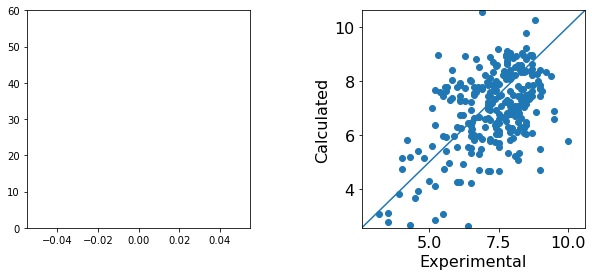

rmse: 1.370, mae: 1.105, r2: 0.497, rho: 0.382


4Y73,9.500,6.875,2.625
3V8T,9.500,6.581,2.919
2WEV,8.700,6.061,2.639
2YEX,10.000,5.766,4.234
3JXW,9.000,5.480,3.520
3D9V,8.233,5.337,2.896
4I5C,7.850,5.323,2.527
2YWP,8.100,5.213,2.887
4MBI,8.200,5.059,3.141
4RIO,9.000,4.700,4.300
3PY0,7.500,4.671,2.829


267
267
Epoch: 1	Lapse: 1.9s	Losses: (2.672, 1.871)	Best: (2.672, 1.871)


/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


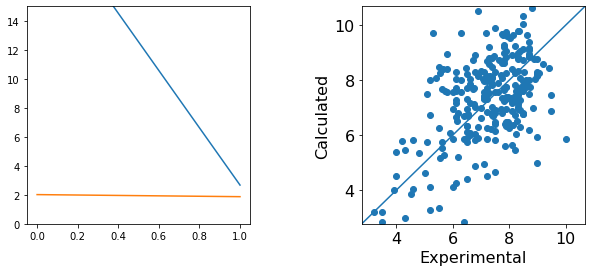

rmse: 1.385, mae: 1.118, r2: 0.506, rho: 0.395


3V8T,9.500,6.888,2.612
3JXW,9.000,5.920,3.080
2YEX,10.000,5.846,4.154
4MBI,8.200,5.457,2.743
4RIO,9.000,4.988,4.012
3PY0,7.500,4.648,2.852
6C3E,7.200,4.512,2.688
2VTM,6.400,2.845,3.555


Epoch: 2	Lapse: 2.0s	Losses: (2.253, 2.217)	Best: (2.253, 1.871)
267
267
Epoch: 3	Lapse: 2.1s	Losses: (2.154, 1.746)	Best: (2.154, 1.746)


/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


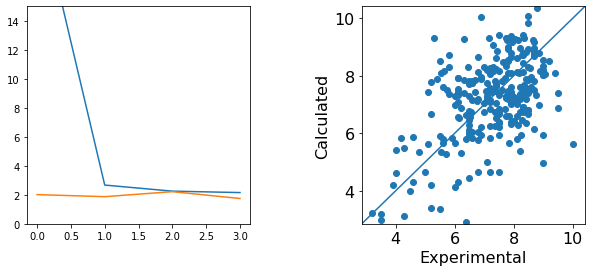

rmse: 1.307, mae: 1.043, r2: 0.513, rho: 0.402


3V8T,9.500,6.887,2.613
2WEV,8.700,6.166,2.534
3JXW,9.000,5.955,3.045
2YEX,10.000,5.636,4.364
4MBI,8.200,5.396,2.804
4RIO,9.000,4.978,4.022
6C3E,7.200,4.671,2.529
3PY0,7.500,4.669,2.831
2VTM,6.400,2.929,3.471


267
267
Epoch: 4	Lapse: 2.0s	Losses: (2.046, 1.344)	Best: (2.046, 1.344)


/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


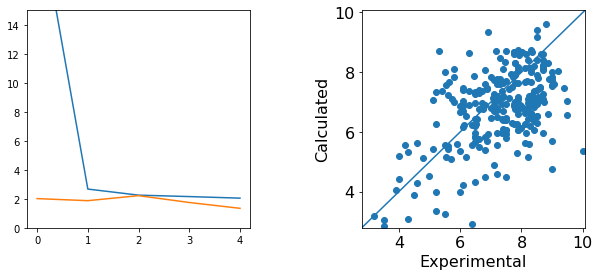

rmse: 1.309, mae: 1.039, r2: 0.518, rho: 0.405


3V8T,9.500,6.554,2.946
2WEV,8.700,5.958,2.742
3JXW,9.000,5.693,3.307
3D9V,8.233,5.602,2.631
2YEX,10.000,5.349,4.651
4I5C,7.850,5.311,2.539
4MBI,8.200,5.163,3.037
4RIO,9.000,4.776,4.224
6C3E,7.200,4.581,2.619
3PY0,7.500,4.506,2.994
2VTM,6.400,2.925,3.475


Epoch: 5	Lapse: 1.9s	Losses: (2.097, 1.697)	Best: (2.046, 1.344)
Epoch: 6	Lapse: 2.0s	Losses: (1.839, 1.360)	Best: (1.839, 1.344)
267
267
Epoch: 7	Lapse: 2.0s	Losses: (1.739, 1.186)	Best: (1.739, 1.186)


/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


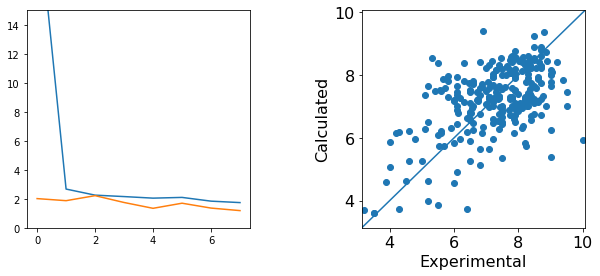

rmse: 1.117, mae: 0.878, r2: 0.543, rho: 0.416


3JXW,9.000,6.246,2.754
2YEX,10.000,5.948,4.052
3D9V,8.233,5.727,2.506
4RIO,9.000,5.380,3.620
2VTM,6.400,3.721,2.679


267
267
Epoch: 8	Lapse: 2.0s	Losses: (1.649, 1.168)	Best: (1.649, 1.168)


/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


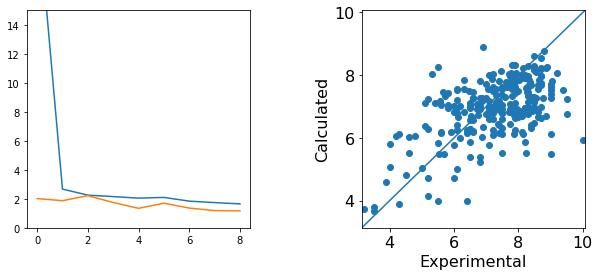

rmse: 1.109, mae: 0.871, r2: 0.557, rho: 0.432


3V8T,9.500,6.773,2.727
3JXW,9.000,6.123,2.877
2YEX,10.000,5.920,4.080
3D9V,8.233,5.521,2.712
4RIO,9.000,5.494,3.506


Epoch: 9	Lapse: 1.9s	Losses: (1.612, 1.475)	Best: (1.612, 1.168)
Epoch: 10	Lapse: 2.0s	Losses: (1.754, 1.883)	Best: (1.612, 1.168)
Epoch: 11	Lapse: 2.0s	Losses: (1.626, 1.556)	Best: (1.612, 1.168)
Epoch: 12	Lapse: 1.9s	Losses: (1.533, 1.251)	Best: (1.533, 1.168)
267
267
Epoch: 13	Lapse: 2.0s	Losses: (1.485, 1.015)	Best: (1.485, 1.015)


/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


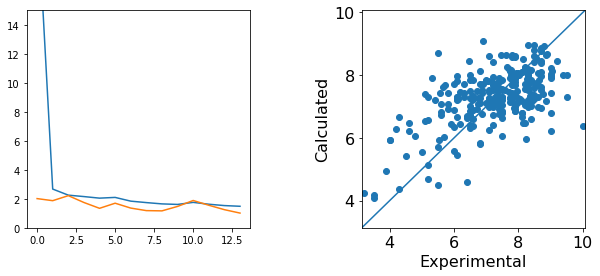

rmse: 1.014, mae: 0.791, r2: 0.588, rho: 0.477


2YEX,10.000,6.365,3.635
4RIO,9.000,6.226,2.774


Epoch: 14	Lapse: 2.0s	Losses: (1.379, 1.052)	Best: (1.379, 1.015)
Epoch: 15	Lapse: 2.0s	Losses: (1.422, 1.354)	Best: (1.379, 1.015)
267
267
Epoch: 16	Lapse: 1.9s	Losses: (1.303, 0.958)	Best: (1.303, 0.958)


/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


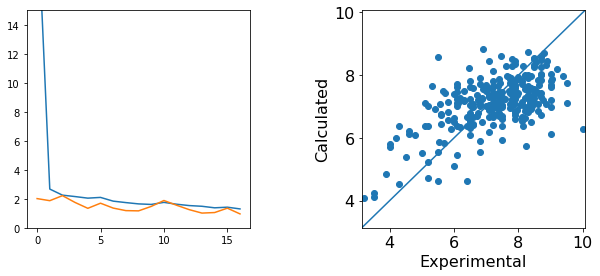

rmse: 1.003, mae: 0.791, r2: 0.603, rho: 0.500


2YEX,10.000,6.272,3.728
4RIO,9.000,6.120,2.880
3D9V,8.233,5.727,2.506


Epoch: 17	Lapse: 2.0s	Losses: (1.284, 0.986)	Best: (1.284, 0.958)
Epoch: 18	Lapse: 1.9s	Losses: (1.272, 1.068)	Best: (1.272, 0.958)
Epoch: 19	Lapse: 2.0s	Losses: (1.346, 0.996)	Best: (1.272, 0.958)
Epoch: 20	Lapse: 2.0s	Losses: (1.313, 1.097)	Best: (1.272, 0.958)
Epoch: 21	Lapse: 2.0s	Losses: (1.456, 1.109)	Best: (1.272, 0.958)
Epoch: 22	Lapse: 2.0s	Losses: (1.294, 1.155)	Best: (1.272, 0.958)
267
267
Epoch: 23	Lapse: 2.0s	Losses: (1.209, 0.816)	Best: (1.209, 0.816)


/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


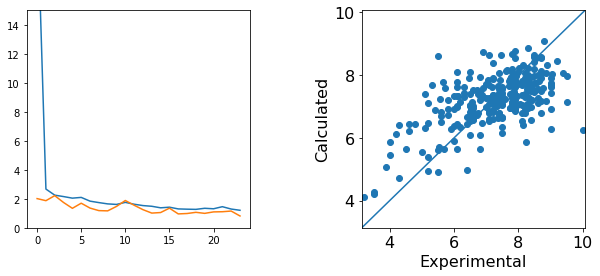

rmse: 0.985, mae: 0.768, r2: 0.611, rho: 0.515


4RIO,9.000,6.283,2.717
2YEX,10.000,6.266,3.734


Epoch: 24	Lapse: 2.0s	Losses: (1.274, 0.856)	Best: (1.209, 0.816)
Epoch: 25	Lapse: 2.0s	Losses: (1.288, 1.241)	Best: (1.209, 0.816)
Epoch: 26	Lapse: 2.0s	Losses: (1.335, 1.077)	Best: (1.209, 0.816)
Epoch: 27	Lapse: 2.0s	Losses: (1.351, 0.946)	Best: (1.209, 0.816)
267
267
Epoch: 28	Lapse: 2.0s	Losses: (1.271, 0.767)	Best: (1.209, 0.767)


/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


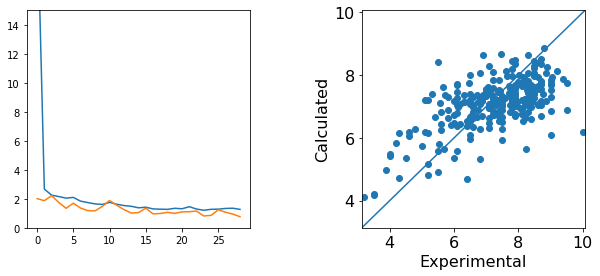

rmse: 0.987, mae: 0.786, r2: 0.622, rho: 0.524


3V8T,9.500,6.882,2.618
2YEX,10.000,6.196,3.804
4RIO,9.000,6.086,2.914
3D9V,8.233,5.653,2.580


Epoch: 29	Lapse: 2.0s	Losses: (1.146, 0.929)	Best: (1.146, 0.767)
Epoch: 30	Lapse: 2.0s	Losses: (1.117, 1.248)	Best: (1.117, 0.767)
Epoch: 31	Lapse: 2.0s	Losses: (1.136, 1.229)	Best: (1.117, 0.767)
Epoch: 32	Lapse: 2.0s	Losses: (1.118, 0.897)	Best: (1.117, 0.767)
Epoch: 33	Lapse: 2.0s	Losses: (1.174, 0.895)	Best: (1.117, 0.767)
Epoch: 34	Lapse: 2.0s	Losses: (1.157, 1.300)	Best: (1.117, 0.767)
Epoch: 35	Lapse: 2.0s	Losses: (1.130, 0.990)	Best: (1.117, 0.767)
Epoch: 36	Lapse: 2.0s	Losses: (1.053, 0.974)	Best: (1.053, 0.767)
Epoch: 37	Lapse: 2.0s	Losses: (1.062, 1.321)	Best: (1.053, 0.767)
Epoch: 38	Lapse: 2.0s	Losses: (1.043, 1.032)	Best: (1.043, 0.767)
Epoch: 39	Lapse: 2.0s	Losses: (1.217, 1.233)	Best: (1.043, 0.767)
Epoch: 40	Lapse: 2.0s	Losses: (1.053, 1.242)	Best: (1.043, 0.767)
Epoch: 41	Lapse: 2.0s	Losses: (1.087, 0.795)	Best: (1.043, 0.767)
Epoch: 42	Lapse: 2.0s	Losses: (1.038, 0.891)	Best: (1.038, 0.767)
Epoch: 43	Lapse: 2.0s	Losses: (1.057, 0.952)	Best: (1.038, 0.767)
Epoch: 44	

/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/share/miniconda3/envs/chem37/lib/python3.7/site-packages/ipykernel_launcher.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


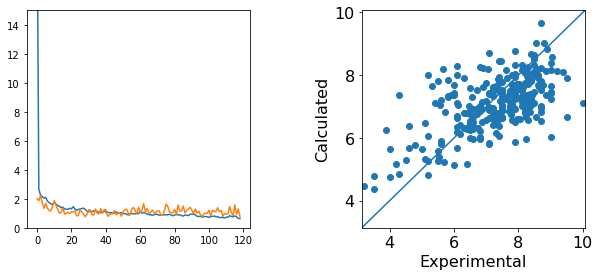

rmse: 1.008, mae: 0.789, r2: 0.608, rho: 0.531


2YEX,10.000,7.113,2.887
3V8T,9.500,6.669,2.831
4RIO,9.000,6.031,2.969


Epoch: 119	Lapse: 2.0s	Losses: (0.642, 1.633)	Best: (0.638, 0.762)
Epoch: 120	Lapse: 1.9s	Losses: (0.820, 1.168)	Best: (0.638, 0.762)
Epoch: 121	Lapse: 2.0s	Losses: (0.741, 0.879)	Best: (0.638, 0.762)
Epoch: 122	Lapse: 2.0s	Losses: (0.745, 1.095)	Best: (0.638, 0.762)
Epoch: 123	Lapse: 2.0s	Losses: (0.824, 0.954)	Best: (0.638, 0.762)
Epoch: 124	Lapse: 2.0s	Losses: (0.772, 1.021)	Best: (0.638, 0.762)
Epoch: 125	Lapse: 2.0s	Losses: (0.797, 1.547)	Best: (0.638, 0.762)
Epoch: 126	Lapse: 2.0s	Losses: (0.782, 0.886)	Best: (0.638, 0.762)
Epoch: 127	Lapse: 2.0s	Losses: (0.791, 0.915)	Best: (0.638, 0.762)
Epoch: 128	Lapse: 2.0s	Losses: (0.811, 1.546)	Best: (0.638, 0.762)
Epoch: 129	Lapse: 2.0s	Losses: (0.769, 1.733)	Best: (0.638, 0.762)
Epoch: 130	Lapse: 2.0s	Losses: (0.788, 1.078)	Best: (0.638, 0.762)
Epoch: 131	Lapse: 1.9s	Losses: (0.760, 1.127)	Best: (0.638, 0.762)
Epoch: 132	Lapse: 1.9s	Losses: (0.703, 1.130)	Best: (0.638, 0.762)
Epoch: 133	Lapse: 2.0s	Losses: (0.704, 0.947)	Best: (0.638, 0.

Epoch: 242	Lapse: 2.0s	Losses: (0.429, 1.437)	Best: (0.335, 0.762)
Epoch: 243	Lapse: 2.0s	Losses: (0.374, 1.107)	Best: (0.335, 0.762)
Epoch: 244	Lapse: 2.0s	Losses: (0.397, 0.963)	Best: (0.335, 0.762)
Epoch: 245	Lapse: 2.0s	Losses: (0.381, 1.399)	Best: (0.335, 0.762)
Epoch: 246	Lapse: 2.0s	Losses: (0.366, 1.099)	Best: (0.335, 0.762)
Epoch: 247	Lapse: 2.0s	Losses: (0.408, 1.130)	Best: (0.335, 0.762)
Epoch: 248	Lapse: 2.0s	Losses: (0.348, 1.130)	Best: (0.335, 0.762)
Epoch: 249	Lapse: 2.0s	Losses: (0.403, 1.242)	Best: (0.335, 0.762)
Epoch: 250	Lapse: 1.9s	Losses: (0.432, 1.915)	Best: (0.335, 0.762)
Epoch: 251	Lapse: 2.0s	Losses: (0.427, 1.163)	Best: (0.335, 0.762)
Epoch: 252	Lapse: 1.9s	Losses: (0.358, 1.159)	Best: (0.335, 0.762)
Epoch: 253	Lapse: 2.0s	Losses: (0.414, 1.102)	Best: (0.335, 0.762)
Epoch: 254	Lapse: 2.0s	Losses: (0.356, 1.566)	Best: (0.335, 0.762)
Epoch: 255	Lapse: 2.0s	Losses: (0.366, 1.131)	Best: (0.335, 0.762)
Epoch: 256	Lapse: 2.0s	Losses: (0.338, 0.978)	Best: (0.335, 0.

In [ ]:
CLEAR_OUTPUT_WHEN_UPDATE = False
SHOW_VERY_BAD_MOLS = True

model = utils.initialize_model(gnn(gnn_opts), device)
print ('number of parameters : ', sum(p.numel() for p in model.parameters() if p.requires_grad))
optimizer = torch.optim.Adam(model.parameters(), lr=learn_opts.lr)
loss_fn = nn.MSELoss()
best_train_loss, best_val_loss = np.inf, np.inf

Los = []
Lps = []

for epoch in range(learn_opts.num_epochs):
    st = time.time()
    train_losses, test_losses = [], []

    model.train()
    train_loss = learn(model, train_dataloader)
    Los.append(train_loss)

    model.eval()
    test_loss = learn(model, test_dataloader, train=False)
    Lps.append(test_loss)

    lapse = time.time() - st

    best_train_loss = update_train_loss(train_loss, best_train_loss)
    best_val_loss, output = update_test_loss(model, myopts, test_loss, best_val_loss, epoch)

    output = output or epoch == learn_opts.num_epochs - 1

    if output:
        X, y, L, S, N = test(model, test_dataloader)
        L = list(itertools.chain.from_iterable(L))
        write_results_to_csv(L, X, y, np.abs(X-y), epoch)
        rmse, mae, r2, rho = get_stats(X, y)
        if CLEAR_OUTPUT_WHEN_UPDATE:
            clear_output()

    ls = [f'Epoch: {epoch}',
          f'Lapse: {lapse:.1f}s',
          f'Losses: ({train_loss:.3f}, {test_loss:.3f})',
          f'Best: ({best_train_loss:.3f}, {best_val_loss:.3f})']
    print('\t'.join(ls))

    if output:
        myplot(X, y, Los, Lps)
        print(f'rmse: {rmse:5.3f}, mae: {mae:5.3f}, r2: {r2:5.3f}, rho: {rho:5.3f}')
        if SHOW_VERY_BAD_MOLS:
            show_bad_molecules(L, X, y, np.abs(X-y), len(X))